In [ ]:
pth = r'/home/zzj/projects/STAND/model_saving/1_STAND_win32_dm256_nl1_bi1_c50.pt'
pth2 = r'/home/zzj/projects/STAND/model_saving/LSTM.pt'
pth3 = r'/home/zzj/projects/STAND/model_saving/M2N2.pt'
proj_pth  = '/home/zzj/projects/STAND/'
import sys
sys.path.append(proj_pth)

import torch
stand_model = torch.load(pth, weights_only=False)
m2n2_model  = torch.load(pth3, weights_only=False)
lstm_model  = torch.load(pth2, weights_only=False)
print(stand_model,m2n2_model,lstm_model)

from utils import get_parse_args
config = get_parse_args()
config.win_size = 32
config.step_size = 10
config.dataset_name = 'SWAT'

from src.data_utils.SimAD_data_loader2 import get_loader_segment, SupervisedDataset

dataset_ = get_loader_segment(config.index, config.dataset_path+'/'+config.dataset_name, config.batch_size, 
                             config.win_size, config.step_size, 'train', config.dataset_name, 0, True)

train_dataset = SupervisedDataset(dataset_.test, dataset_.test_labels, config.win_size, config.step_size, 'train', config.train_test_split)

train_y = train_dataset.train
train_labels = train_dataset.train_labels
test_y = train_dataset.test
test_labels = train_dataset.test_labels
all_test_y = train_dataset.all_test_y
all_test_labels = train_dataset.all_test_labels

STAND(batch_size=128, bidirectional=1, contamination=0.1, d_model=300,
   debug=0, device='cuda', epochs=10, lr=0.001, normalize=False,
   num_layers=1, optimizer=None, win_size=32) M2N2(batch_size=128, epochs=10, gamma=None, if_save=1, latent_dim=None,
   lr=0.0001,
   model_saving_path=PosixPath('/home/zzj/projects/STAND/model_saving'),
   normalization='Detrend', num_channels=None, stride=10, th=0.95,
   win_size=20) <src.models.LSTMAD.LSTMAD object at 0x704ddbd51100>
test: (449919, 50)
train: (495000, 50)


In [20]:
stand_scores = stand_model.decision_function(test_y)
m2n2_scores = m2n2_model.decision_function(test_y)
lstm_scores = lstm_model.decision_function(test_y)
print(m2n2_scores)

======================TEST MODE======================


Testing: : 100%|██████████| 1757/1757 [00:17<00:00, 98.50it/s] 


[0.00453344 0.00519547 0.00518284 ... 0.00306147 0.00306147 0.00306147]


In [21]:
s1 = (lstm_scores - lstm_scores.min())/(lstm_scores.max()-lstm_scores.min())
s2 = (m2n2_scores - m2n2_scores.min())/(m2n2_scores.max()-m2n2_scores.min())
s3 = (stand_scores - stand_scores.min())/(stand_scores.max()-stand_scores.min())
score_list = [s1,s2,s3]

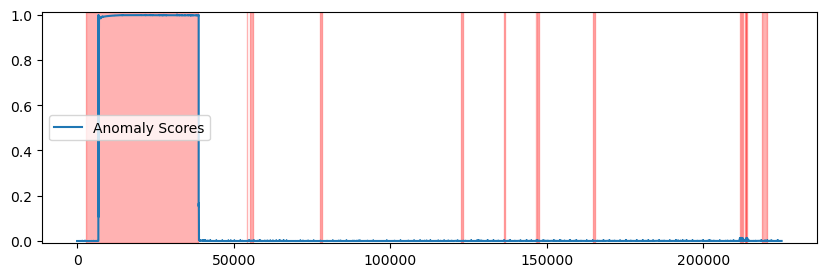

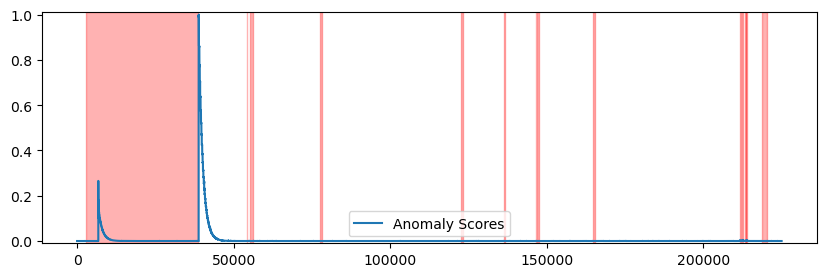

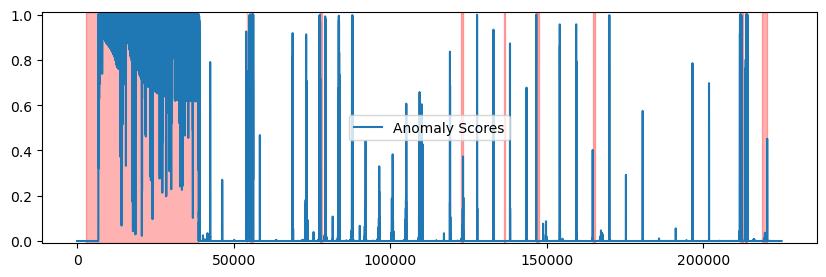

In [22]:
def plot_scores_vs_labels(scores, labels):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,3))
    from cce.metrics.basic_metrics import basic_metricor
    bm = basic_metricor()
    plt.plot(scores, label='Anomaly Scores')
    show_range = [0,labels.shape[0]]
    anom_ranges = bm.range_convers_new(labels)
    for i, anom_range in enumerate(anom_ranges):
        plt.axvspan(anom_range[0]-show_range[0], anom_range[1]-show_range[0], color='red', alpha=0.3)#, label='Anomaly Range' if i==0 else None)
    plt.legend()
    plt.ylim(-0.01,1.01)
    plt.show()

for s in score_list:
    plot_scores_vs_labels(s, test_labels)